# BCI Competition IV Dataset 2a - Information

---

## Dataset Overview
- 9 subjects (**A01 to A09**)  
- 4 motor imagery classes:  
  * **Class 1**: Left hand  
  * **Class 2**: Right hand  
  * **Class 3**: Both feet  
  * **Class 4**: Tongue  

---

## Recording Setup
- 22 EEG channels (monopolar)  
- 3 EOG channels  
- Sampling rate: **250 Hz**  
- Reference: left mastoid  
- Ground: right mastoid  

---

## File Naming Convention
- `A[01-09]T.gdf`: Training data  
- `A[01-09]E.gdf`: Evaluation data  

---

## Trial Structure
- Trial length: **7.5 seconds**  
- Cue at **t = 2s**  
- Motor imagery: **t = 2s to t = 6s**  
- Preprocessing window: **t = 2.5s to t = 4.5s** (0.5–2.5s post-cue)  


In [70]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.io import loadmat
import mne
import os
import warnings
warnings.filterwarnings('ignore')

# Define EEG channels (example: standard 22 EEG channels for BCI Competition IV 2a)
EEG_CHANNELS = [
    'EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5',
    'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9',
    'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15', 'EEG-16'
]




In [71]:
def load_gdf_file(filepath):
    """Load GDF file with proper scaling for BCI IV 2a"""
    raw = mne.io.read_raw_gdf(filepath, preload=True, verbose=False)
    
    # Apply the correct scaling for BCI Competition IV 2a
    # The data is stored in microvolts but might need scaling
    raw.apply_function(lambda x: x * 1e6)  # Convert to microvolts if needed
    
    events, event_dict = mne.events_from_annotations(raw)
    print(f"Event dictionary mapping: {event_dict}")
    return raw, events, event_dict
    
def extract_labels_from_events(events, event_mapping=None):
    """Extract motor imagery labels from events"""
    if event_mapping is None:
        event_mapping = {769:1, 770:2, 771:3, 772:4}  # Default BCI IV 2a
    mi_events = events[np.isin(events[:, 2], list(event_mapping.keys()))]
    labels = np.array([event_mapping[e[2]] for e in mi_events])
    trial_starts = mi_events[:, 0]
    return labels, trial_starts


In [72]:
def check_raw_data(filepath):
    """Debug function to check raw data before processing"""
    raw = mne.io.read_raw_gdf(filepath, preload=True, verbose=False)
    
    print(f"Raw data shape: {raw.get_data().shape}")
    print(f"Data range: {np.min(raw.get_data())} to {np.max(raw.get_data())}")
    print(f"Data mean: {np.mean(raw.get_data())}")
    print(f"Channels: {raw.ch_names}")
    
    # Plot a small segment of raw data
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(12, 6))
    data_sample = raw.get_data()[0, :1000]  # First channel, first 1000 samples
    ax.plot(data_sample)
    ax.set_title('Raw EEG Data (First Channel, First 1000 samples)')
    ax.set_xlabel('Samples')
    ax.set_ylabel('Amplitude')
    plt.show()
    
    return raw

In [73]:
class BCIPreprocessor:
    # """
    # Preprocessing pipeline for BCI Competition IV 2a dataset.
    # Automatically selects available EEG channels and handles edge cases.
    # """
    
    def __init__(self, l_freq=8, h_freq=30, notch_freq=50, sfreq=250):
        self.l_freq = l_freq
        self.h_freq = h_freq
        self.notch_freq = notch_freq
        self.sfreq = sfreq
        
        print(f" Preprocessor initialized:")
        print(f"   - Bandpass filter: {l_freq}-{h_freq} Hz")
        print(f"   - Notch filter: {notch_freq} Hz")
        print(f"   - Sampling rate: {sfreq} Hz")
    
    def apply_bandpass_filter(self, raw):
        print(f"Applying bandpass filter ({self.l_freq}-{self.h_freq} Hz)...")
        raw_filtered = raw.copy()
        raw_filtered.filter(
            l_freq=self.l_freq, h_freq=self.h_freq,
            method='iir', iir_params={'order': 4, 'ftype': 'butter'},
            verbose=False
        )
        return raw_filtered
    
    def apply_notch_filter(self, raw):
        print(f" Applying notch filter ({self.notch_freq} Hz)...")
        raw_notched = raw.copy()
        raw_notched.notch_filter(freqs=self.notch_freq, verbose=False)
        return raw_notched
    
    def epoch_data(self, raw, trial_starts, labels, tmin=0.5, tmax=2.5):
        print(f" Creating epochs ({tmin}s to {tmax}s post-cue)...")
        smin = int(tmin * self.sfreq)
        smax = int(tmax * self.sfreq)
        n_samples = smax - smin

        # Select only available EEG channels
        available_channels = [ch for ch in EEG_CHANNELS if ch in raw.ch_names]
        if not available_channels:
            raise ValueError("No EEG channels found in the raw data!")
        print(f"Using EEG channels: {available_channels}")
        eeg_indices = [raw.ch_names.index(ch) for ch in available_channels]
        data = raw.get_data()[eeg_indices, :]

        epochs_data, valid_labels = [], []

        for i, (start_sample, label) in enumerate(zip(trial_starts, labels)):
            epoch_start = start_sample + smin
            epoch_end = start_sample + smax

            # Handle epochs exceeding data boundaries
            if epoch_start >= data.shape[1]:
                print(f"Trial {i+1} skipped: epoch start beyond data length")
                continue
            if epoch_end > data.shape[1]:
                epoch_end = data.shape[1]  # truncate
                print(f" Trial {i+1} truncated: epoch end adjusted to {epoch_end}")

            epoch = data[:, epoch_start:epoch_end]
            if epoch.shape[1] < n_samples:
                print(f"Trial {i+1} warning: epoch length shorter than expected ({epoch.shape[1]} samples)")
            epochs_data.append(epoch)
            valid_labels.append(label)
        
        epochs_data = np.array(epochs_data)
        valid_labels = np.array(valid_labels)
        
        print(f" Created {len(epochs_data)} epochs:")
        if len(epochs_data) > 0:
            print(f"   - Shape: {epochs_data.shape} [trials, channels, samples]")
        print(f"   - Requested duration: {n_samples/self.sfreq:.2f} seconds")
        
        return epochs_data, valid_labels
    
    def preprocess_subject(self, filepath, tmin=0.5, tmax=2.5):
        print(f"\n{'='*60}")
        print(f" Preprocessing: {os.path.basename(filepath)}")
        print(f"{'='*60}")

        # 1. Load raw data with event mapping
        raw, events, event_dict = load_gdf_file(filepath)
        print(f"Event codes in data: {np.unique(events[:, 2])}")

        # 2. Find the correct mapping for trial start and MI events
        # Reverse the event_dict to see what MNE mapped to what
        reverse_mapping = {v: k for k, v in event_dict.items()}
        print(f"Reverse mapping: {reverse_mapping}")

        # Find which MNE code corresponds to original codes
        trial_start_code = None
        mi_codes = {}
        
        for mne_code, orig_code_str in reverse_mapping.items():
            try:
                orig_code = int(orig_code_str)
                if orig_code == 768:
                    trial_start_code = mne_code
                elif orig_code in [769, 770, 771, 772]:
                    mi_codes[mne_code] = orig_code - 768  # Map to class 1-4
            except ValueError:
                continue

        print(f"Trial start code (768): {trial_start_code}")
        print(f"MI codes mapping: {mi_codes}")

        if trial_start_code is None or not mi_codes:
            print(" Could not find required event codes!")
            return np.array([]), np.array([])

        # 3. Extract trials
        trial_starts = []
        labels = []

        for i, event in enumerate(events):
            code = event[2]
            if code == trial_start_code and i+1 < len(events):
                next_code = events[i+1][2]
                if next_code in mi_codes:
                    trial_starts.append(event[0])
                    labels.append(mi_codes[next_code])

        trial_starts = np.array(trial_starts)
        labels = np.array(labels)

        if len(labels) == 0:
            print(" No motor imagery events found!")
            return np.array([]), np.array([])

        print(f"Extracted {len(labels)} trials:")
        class_names = ['Left hand', 'Right hand', 'Both feet', 'Tongue']
        for class_id in range(1,5):
            count = np.sum(labels == class_id)
            print(f"   - Class {class_id} ({class_names[class_id-1]}): {count} trials")

        # 4. Apply filters
        raw_bp = self.apply_bandpass_filter(raw)
        raw_clean = self.apply_notch_filter(raw_bp)

        # 5. Create epochs
        epochs_data, valid_labels = self.epoch_data(raw_clean, trial_starts, labels, tmin, tmax)

        print(f" Preprocessing completed for {os.path.basename(filepath)}")
        return epochs_data, valid_labels



In [74]:
def assess_data_quality(epochs_data, labels, subject_id):
    """
    Assess the quality of preprocessed data.
    Handles empty or zero-length epoch arrays gracefully.
    """
    print(f"\n data Quality Assessment - {subject_id}")
    print("-" * 40)

    if epochs_data.size == 0:
        print(" No epochs available for this subject.")
        print(f"Labels array length: {len(labels)}")
        return

    n_trials, n_channels, n_samples = epochs_data.shape
    print(f"Trials: {n_trials}")
    print(f"Channels: {n_channels}")
    print(f"Samples per trial: {n_samples}")
    print(f"Sampling rate: 250 Hz")
    print(f"Trial duration: {n_samples/250:.2f}s")

    # Class distribution
    print("\nClass distribution:")
    class_names = ['Left hand', 'Right hand', 'Both feet', 'Tongue']
    for class_id in range(1, 5):
        count = np.sum(labels == class_id)
        percentage = count / len(labels) * 100 if len(labels) > 0 else 0
        print(f"  Class {class_id} ({class_names[class_id-1]}): {count} ({percentage:.1f}%)")

    # Signal statistics
    mean_amplitude = np.mean(np.abs(epochs_data))
    std_amplitude = np.std(epochs_data)
    max_amplitude = np.max(np.abs(epochs_data))

    print("\nSignal statistics (µV):")
    print(f"  Mean absolute amplitude: {mean_amplitude:.2f}")
    print(f"  Standard deviation: {std_amplitude:.2f}")
    print(f"  Maximum amplitude: {max_amplitude:.2f}")

    # Artifact detection
    artifact_threshold = 100  # µV
    artifact_trials = np.any(np.abs(epochs_data) > artifact_threshold, axis=(1, 2))
    n_artifacts = np.sum(artifact_trials)
    print(f"\nArtifact detection (>{artifact_threshold}µV):")
    print(f"  Trials with potential artifacts: {n_artifacts} ({n_artifacts/n_trials*100:.1f}%)")
    if n_artifacts > 0:
        print("   Consider additional artifact removal")


def plot_sample_data(epochs_data, labels, subject_id, n_samples=4):
    """
    Plot sample trials for each class.
    Handles empty epoch arrays gracefully.
    """
    if epochs_data.size == 0:
        print(f" No data to plot for {subject_id}")
        return

    fig, axes = plt.subplots(4, n_samples, figsize=(15, 12))
    fig.suptitle(f'Sample EEG Trials - {subject_id}', fontsize=16, fontweight='bold')

    class_names = ['Left hand', 'Right hand', 'Both feet', 'Tongue']
    time_axis = np.linspace(0.5, 2.5, epochs_data.shape[2])

    for class_id in range(1, 5):
        class_trials = epochs_data[labels == class_id]
        for sample_idx in range(min(n_samples, len(class_trials))):
            ax = axes[class_id-1, sample_idx]
            channels_to_plot = [2, 7, 9, 11]  # example channels
            for ch_idx in channels_to_plot:
                if ch_idx < class_trials.shape[1]:  # ensure index exists
                    ax.plot(time_axis, class_trials[sample_idx, ch_idx, :], alpha=0.7, linewidth=1)
            ax.set_title(f'{class_names[class_id-1]} - Trial {sample_idx+1}')
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Amplitude (µV)')
            ax.grid(True, alpha=0.3)
            ax.set_ylim(-50, 50)
    plt.tight_layout()
    plt.show()



Raw data shape: (25, 672528)
Data range: -0.016 to 0.0006679687499999999
Data mean: -3.3041127736967883e-06
Channels: ['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5', 'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9', 'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15', 'EEG-16', 'EOG-left', 'EOG-central', 'EOG-right']


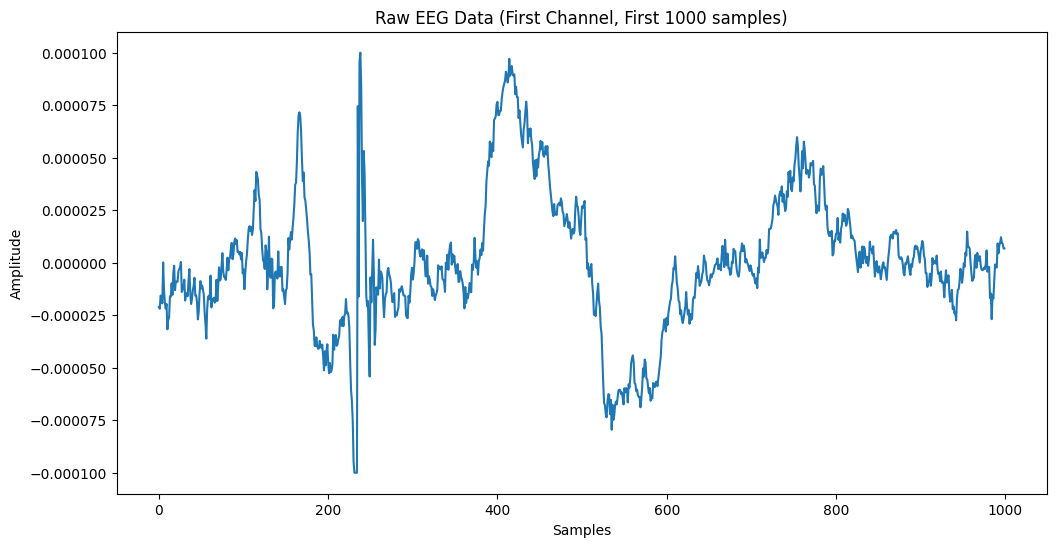

 Preprocessor initialized:
   - Bandpass filter: 8-30 Hz
   - Notch filter: 50 Hz
   - Sampling rate: 250 Hz

 Preprocessing: A01T.gdf
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Event dictionary mapping: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}
Event codes in data: [ 1  2  3  4  5  6  7  8  9 10]
Reverse mapping: {1: '1023', 2: '1072', 3: '276', 4: '277', 5: '32766', 6: '768', 7: '769', 8: '770', 9: '771', 10: '772'}
Trial start code (768): 6
MI codes mapping: {7: 1, 8: 2, 9: 3, 10: 4}
Extracted 273 trials:
   - Class 1 (Left hand): 69 trials
   - Class 2 (Right hand): 69 trials
   - Class 3 (Both feet): 68 trials
   - Class 4 (Tongue): 67 trials
Applying bandpass filter (8-30 Hz)...
 Applying notch filter (50 Hz)...
 Creating epochs (0.5s to 2.5s post-cue)...
Using EEG channels: ['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5', 'EEG-C3', 'EEG-6

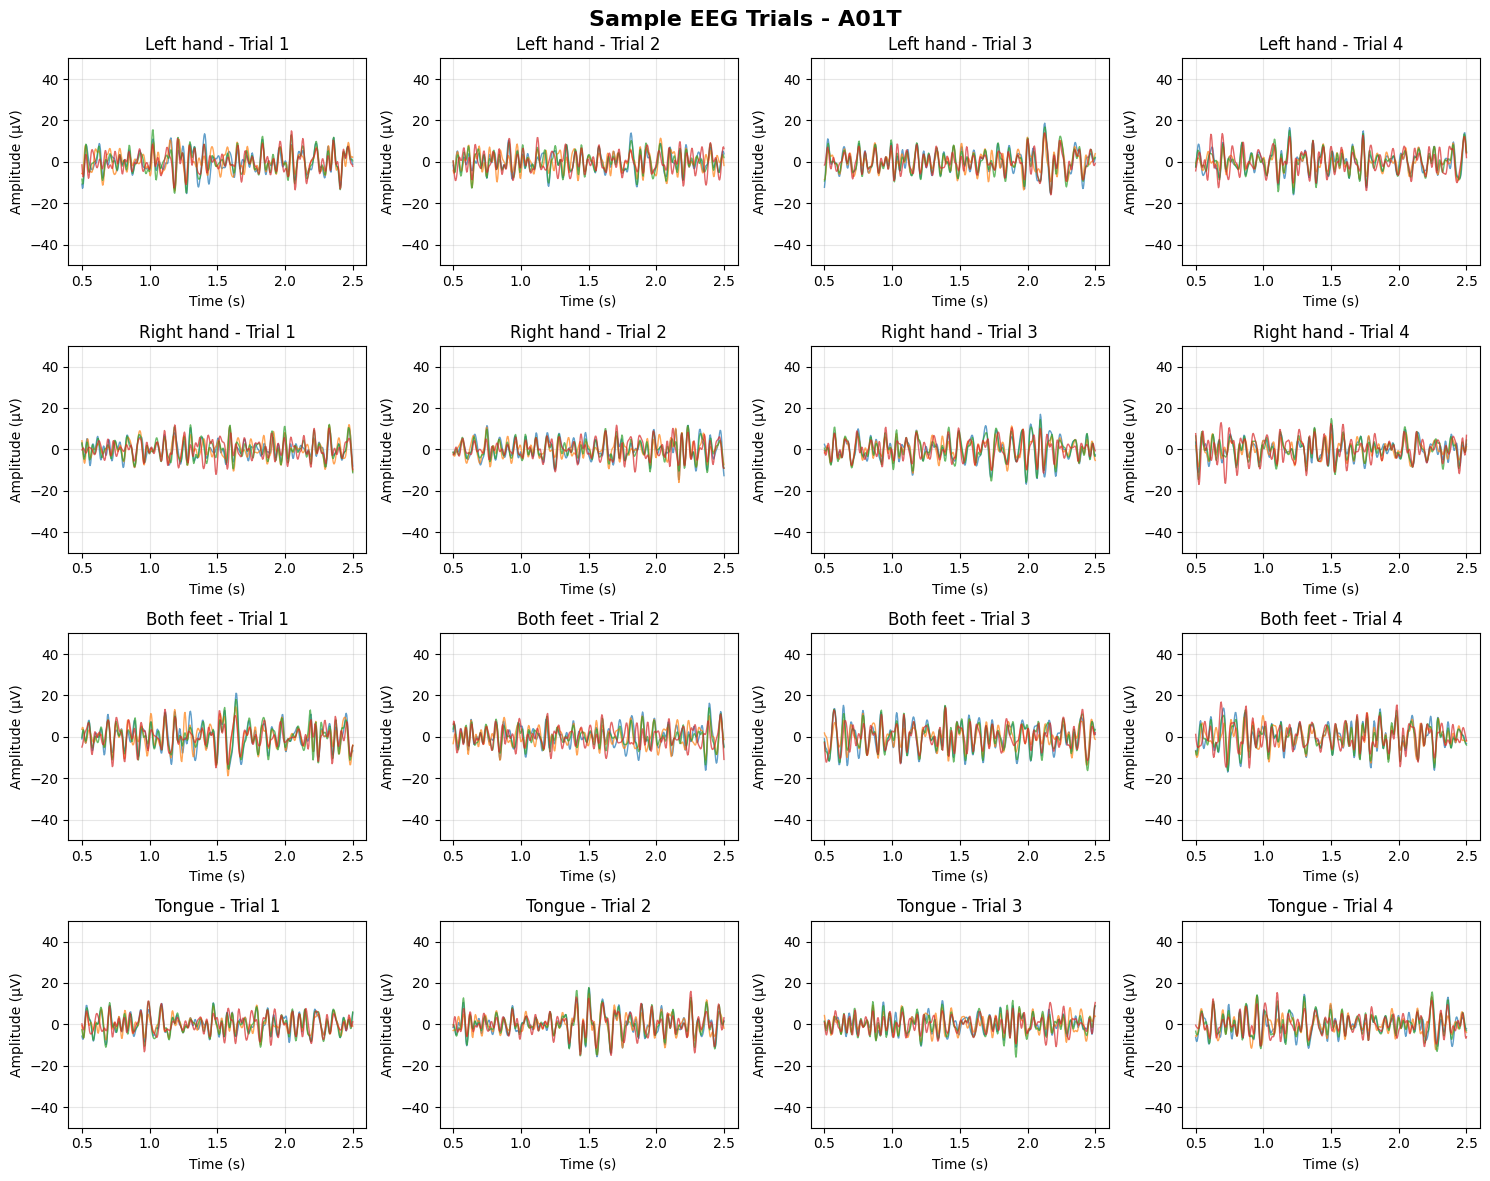

In [75]:
DATA_DIR = "/home/azad/Desktop/AdaptiveHybridBCI/data"  # Update to your folder with GDF files
subject_id = "A01"
session = "T"
raw = check_raw_data(filepath)
preprocessor = BCIPreprocessor()
filepath = os.path.join(DATA_DIR, f"{subject_id}{session}.gdf")
epochs_data, labels = preprocessor.preprocess_subject(filepath)
assess_data_quality(epochs_data, labels, f"{subject_id}{session}")
plot_sample_data(epochs_data, labels, f"{subject_id}{session}")
